# Setup

In [3]:
using Revise

import SuperconductingCircuits as SCC
import QuantumToolbox as qt

import CairoMakie as cm

using Logging
using MiniLoggers

In [4]:
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)
global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(18) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Designing an $\ket{f0}\leftrightarrow\ket{g1}$ Sideband

### Defining The Circuit

In [5]:
transmon_params = Dict{Symbol, Any}()
transmon_params[:name] = "transmon"
transmon_params[:EJ] = 26.96976142643705
transmon_params[:EC] = 0.10283303447280807
transmon_params[:N] = 10
transmon_params[:N_full] = 60

transmon = SCC.Circuits.init_components["transmon"](transmon_params)

resonator_params = Dict{Symbol, Any}()
resonator_params[:name] = "resonator"
resonator_params[:Eosc] = 6.228083962082612
resonator_params[:N] = 10

resonator = SCC.Circuits.init_components["resonator"](resonator_params)

interactions = [[0.026877206812551357, ":n_op", "1im*(:a_op-:a_op')"]]
circuit = SCC.Circuits.init_circuit([transmon, resonator], interactions; operators_to_add = Dict("nt"=>[":n_op", ""]));

## Calibrating Sideband

Basic Parameters:

In [ ]:
envelope = "bump_ramp"
amplitude = 0.735
base_freq = circuit.dressed_energies[(0,1)] - circuit.dressed_energies[(2,0)]
phase = 0
delay = 0.0
drive_time = 10
ramp_time = 11
envelope_params = Dict(:k => 2, :ramp_time => ramp_time)

drive_coef_param = SCC.Dynamics.StaticDriveCoefParam(envelope = envelope, envelope_params = envelope_params, amplitude = amplitude, frequency = base_freq, phase = phase, delay = delay, drive_time = drive_time)

SuperconductingCircuits.Dynamics.StaticDriveCoefParam("bump_ramp", Dict{Symbol, Any}(:ramp_time => 11, :k => 2), -2.8699623474273466, 0, 0.735, 10, 0.0)

### Using Floquet to find the resonant frequency

[2025-05-09 20:05:34] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


[2025-05-09 20:05:49] Info: Done With Floquet Sweep
[2025-05-09 20:05:49] Info: Tracking State
[2025-05-09 20:05:49] Info: Resonance at : 2.8323025315926387 GHz
[2025-05-09 20:05:49] Info: Approximate Drive Time: 193.0435953925961


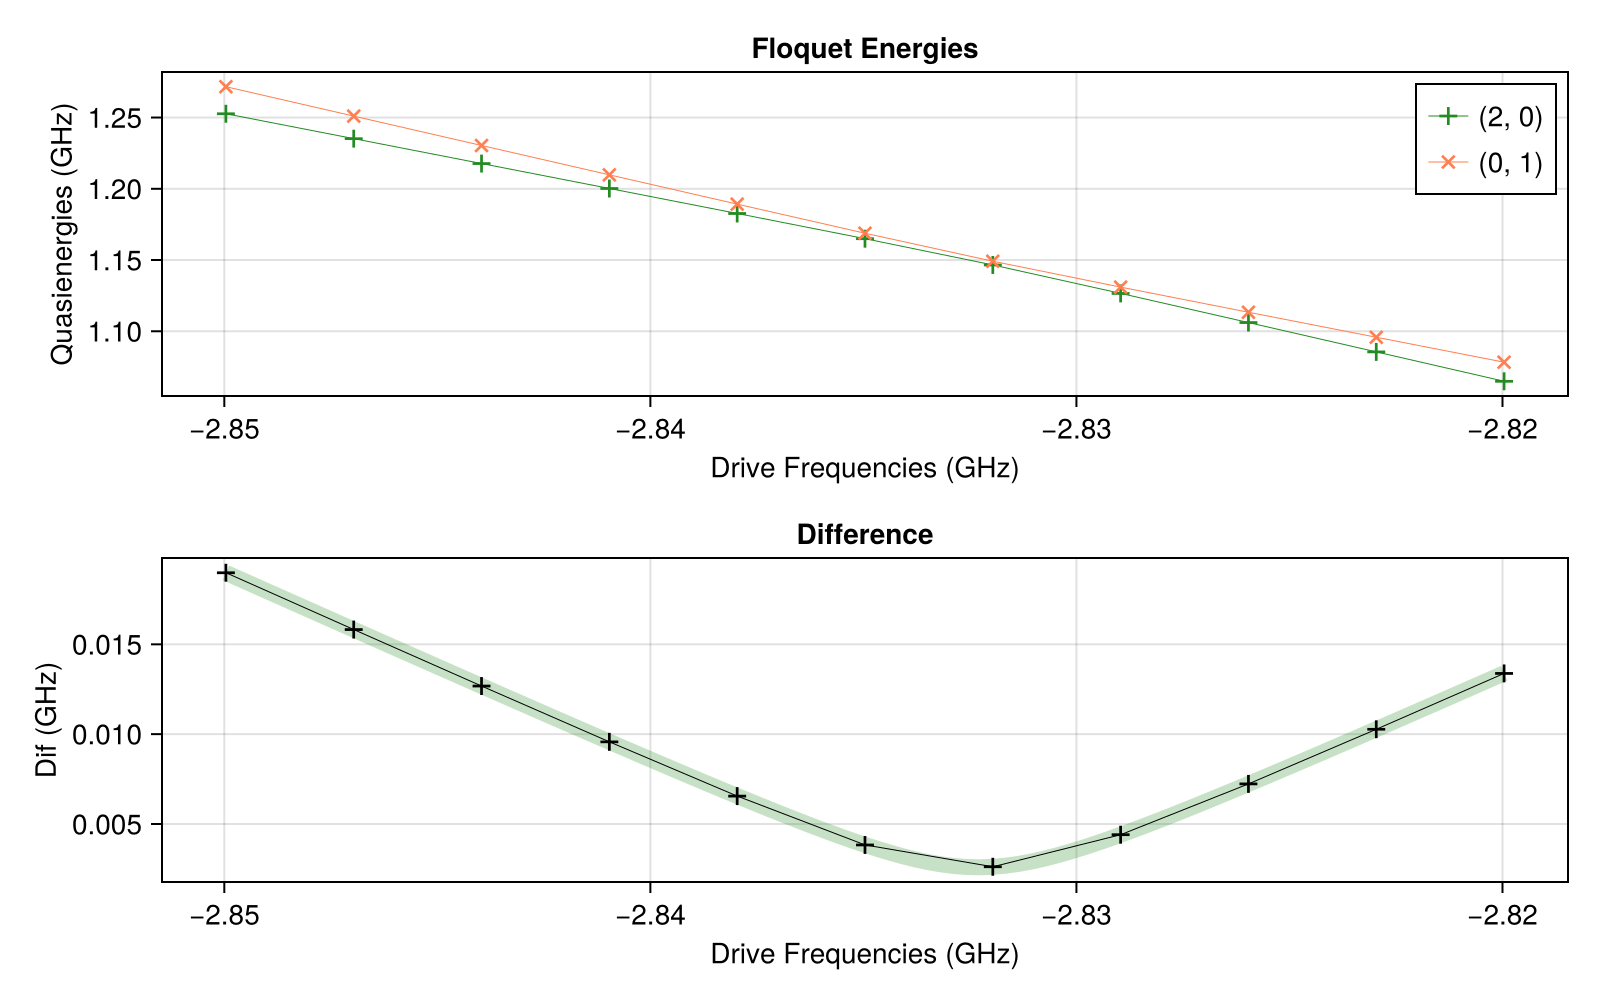

193.0435953925961

In [17]:
reference_states = Dict{Any, Any}((0,1) => circuit.dressed_states[(0,1)], (2,0) => circuit.dressed_states[(2,0)])
stark_shifts = LinRange(0.02, 0.05, 11)
res_res = SCC.Dynamics.find_resonance(circuit.H_op, circuit.ops["nt"], base_freq.+stark_shifts, amplitude, reference_states; show_plot = true)

drive_coef_param.frequency = res_res[1]
drive_coef_param.drive_time = res_res[2]


### Calibrating Drive Time

In [23]:
psi0 = circuit.dressed_states[(2,0)]
psi_targ = circuit.dressed_states[(0,1)]
to_min(psi) = 1-abs(psi_targ'*psi)^2
drive = SCC.Dynamics.calibrate_drive_time(drive_coef_param, circuit, "nt", [res_res[2], res_res[2]+2*ramp_time], psi0, to_min);

[2025-05-09 20:08:40] Info: Times: [193.0435953925961, 198.5435953925961, 204.0435953925961, 209.5435953925961, 215.0435953925961]
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2025-05-09 20:08:50] Info: Iter 1 mins: Any[0.008723476769146643, 0.002506661025240109, 0.0002805402394163714, 0.002063080478796775, 0.00783990497858511]
[2025-05-09 20:08:50] Info: Minimum Beats Tolerance: Any[0.008723476769146643, 0.002506661025240109, 0.0002805402394163714, 0.002063080478796775, 0.00783990497858511][j_best]
[2025-05-09 20:08:50] Info: Best Time: 204.04359539259

In [24]:
res = qt.sesolve(2*pi*(drive.drive), psi0, 0:0.1:drive.drive_time)

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)


Solution of time evolution
(return code: Success)
--------------------------
num_states = 2041
num_expect = 0
ODE alg.: OrdinaryDiffEqTsit5.Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false))
abstol = 1.0e-8
reltol = 1.0e-6


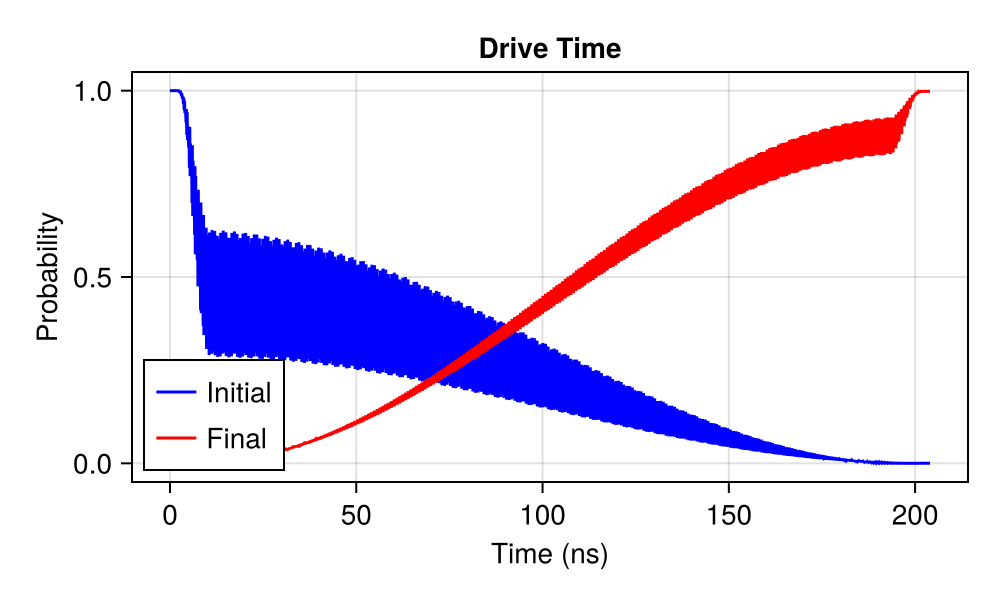

CairoMakie.Screen{IMAGE}


In [25]:
fig = cm.Figure(size = (500, 300))
ax = fig[1, 1] = cm.Axis(fig; title = "Drive Time", xlabel = "Time (ns)", ylabel = "Probability")
x = res.times

y = [abs(psi0'*res.states[i])^2 for i in 1:length(res.states)]
cm.lines!(ax, x, y; color = :blue, label = "Initial")

y = [abs(psi_targ'*res.states[i])^2 for i in 1:length(res.states)]
cm.lines!(ax, x, y; color = :red, label = "Final")
cm.axislegend(ax, position = :lb)
display(fig)
